# 0. Imports

In [1]:
import os
import torch
from PIL import Image
from src.dataset_and_loader.loader import get_transform
from src.dataset_and_loader.dataset import RecipeDataset
from src.dataset_and_loader.loader import dataset_loader
from src.model import FusionModel
from src.model import InfoNCELoss
from src.utils.save import load_model
from src.pipeline import train_and_validate_model
from src.reterival import retrieve
from src.utils.plot import show_image
from src.utils.utils import count_trainable_params
from src.utils.utils import count_total_params
from src.utils.utils import get_device
from src.pipeline import encode_texts_in_batches
from src.pipeline import prepare_dataset_tensors
from src.utils.plot import plot_training_n_validation_loss
from src.utils.save import load_training_n_validation_loss

/Users/sumanneupane/Documents/MIT in AI/Semister 3/Neural Networks and Deep Learning/coursework/cross_modal_text_image/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Hyperparameters

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
TEMPERATURE = 0.05
MODEL_PATH = "fusion_model.pth"
device = get_device()

Using Apple MPS


In [3]:
# optimize batch sizes for mps= MAC
torch.set_float32_matmul_precision("high")
torch.backends.mps.enable = True
torch.backends.mps.float32_matmul_precision = "high"  # "high" or "medium"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# 2. Dataset and DataLoader

In [4]:
base_dir = os.getcwd()
csv_path = os.path.join(base_dir, "data", "Food Ingredients and Recipe Dataset with Image Name Mapping.csv")
image_dir = os.path.join(base_dir, "data", "Food Images")

train_transform, val_transform = get_transform(IMAGE_SIZE)
full_dataset = RecipeDataset(csv_file=csv_path, image_dir=image_dir, transform=train_transform)
train_loader, val_loader = dataset_loader(full_dataset, train_transform, val_transform, BATCH_SIZE)

Train size: 5400, Val size: 5400


# 3. Initializations

In [5]:
model = FusionModel(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fun = InfoNCELoss(temperature=TEMPERATURE)
model

FusionModel(
  (text_encoder): TextEncoder(
    (bert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): DistilBertSdpaAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              

In [6]:
model, optimizer, last_epoch = load_model(model, optimizer, path=MODEL_PATH, device=device)

Model loaded from fusion_model.pth (last epoch: 45)


In [7]:
print(f"Trainable params: {count_trainable_params(model)}")
print(f"Total params: {count_total_params(model)}")

Trainable params: 163061824
Total params: 163061824


# 4. Train and Validate Model

In [ ]:
pre_last_epoch = last_epoch
if pre_last_epoch > 1:
    pre_last_epoch += 1
TRAIN_NEXT_EPOCHS = 10
TOTAL_EPOCHS = pre_last_epoch + TRAIN_NEXT_EPOCHS
print(f"Start epoch: {last_epoch}, Total epochs: {pre_last_epoch + TRAIN_NEXT_EPOCHS - 1}")

In [ ]:
train_and_validate_model(
    model, train_loader, val_loader,
    optimizer, loss_fun, device,
    start_epoch=pre_last_epoch,
    epochs=TRAIN_NEXT_EPOCHS,
    save_path=MODEL_PATH
)

# 5. Evaluation metrices and Plot Graph

### a. Train and Validate Loss Graph

Loss loaded from metrics/training_and_validation_loss_log.csv


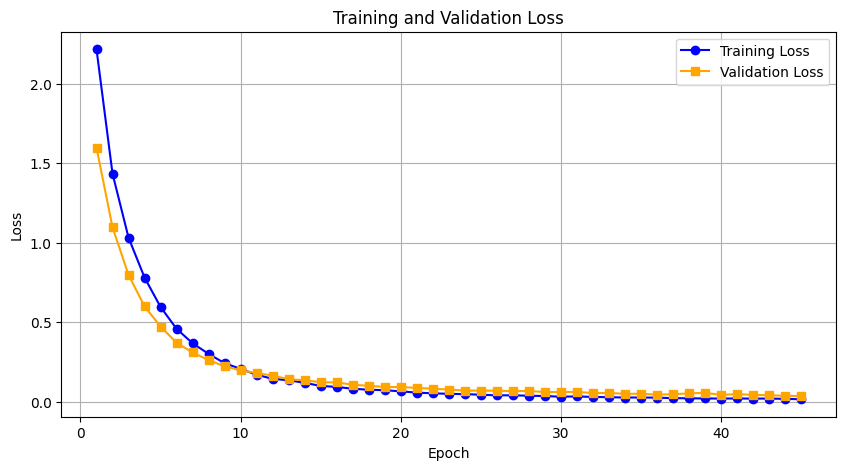

In [8]:
epochs, train_loss, val_loss = load_training_n_validation_loss()
plot_training_n_validation_loss(epochs, train_loss, val_loss)


# 6. Test Model

In [ ]:
loaded_model, _, _ = load_model(model, optimizer, path=MODEL_PATH, device=device)

### a. Dataset Embeddings

In [ ]:
dataset_texts, dataset_ingredients_instructions, dataset_metadata, dataset_images = prepare_dataset_tensors(
    full_dataset,
    desc="Preparing texts, images & metadata"
)

In [ ]:
dataset_title_embeds = encode_texts_in_batches(
    loaded_model,
    dataset_texts,
    batch_size=BATCH_SIZE,
    device=device,
    desc="Building titles embeddings:"
)

In [ ]:
dataset_ingredients_instructions_embeds = encode_texts_in_batches(
    loaded_model,
    dataset_ingredients_instructions,
    batch_size=BATCH_SIZE,
    device=device,
    desc="Building Ingredients and Instructions embeddings: "
)

In [ ]:
from src.pipeline import encode_images_in_batches

dataset_image_embeds = encode_images_in_batches(
    model=loaded_model,
    dataset_images=dataset_images,
    device=device
)

In [ ]:
print(dataset_title_embeds.shape)
print(dataset_ingredients_instructions_embeds.shape)
print(dataset_image_embeds.shape)

### b. Retrieve from your query

#### i. text -> title

In [ ]:
query_texts = ["crispy salt and pepper potatoes"]

# Retrieve
results = retrieve(
    model=loaded_model,
    query_texts=query_texts,
    query_images=None,
    dataset_title_embeds=dataset_title_embeds,
    dataset_ingredients_instructions_embeds=None,
    dataset_image_embeds=None,
    top_k=3,
    device=device
)

# Example access
indices, scores = results["text->text"]
print("text->ingredients_instructions indices:", indices)
print("text->ingredients_instructions scores:", scores)


In [ ]:
# Loop through the hits
for rank, idx in enumerate(indices[0]):  # 0 because batch size is 1
    idx = idx.item()  # convert from tensor to int
    sample = full_dataset[idx]
    print(f"{rank + 1}. Score: {scores[0][rank].item():.3f}")
    print(f"   Title: {sample['metadata']['title']}")

    text = sample['target_text']
    text = " ".join(text) if isinstance(text, list) else str(text)
    short_text = text[:100] + "..." if len(text) > 100 else text
    print(f"   Ingredients+Instructions: {short_text}")

#### ii. image -> image

In [ ]:
image_name = "crispy-salt-and-pepper-potatoes-dan-kluger"
image_dir = os.path.join(base_dir, "data", "Food Images")
image_path = os.path.join(image_dir, image_name + ".jpg")
img = Image.open(image_path).convert("RGB")
img_tensor = val_transform(img)
img_tensor = img_tensor.unsqueeze(0)  # add batch dimension [1, C, H, W]
query_images = img_tensor.to(device)

# Retrieve
results = retrieve(
    model=loaded_model,
    query_texts=None,
    query_images=query_images,
    dataset_title_embeds=None,
    dataset_ingredients_instructions_embeds=None,
    dataset_image_embeds=dataset_image_embeds,
    top_k=3,
    device=device
)

# Example access
indices, scores = results["image->image"]
print("image->image indices:", indices)
print("image->image scores:", scores)

In [ ]:
# Loop through the hits
for rank, idx in enumerate(indices[0]):  # 0 because batch size is 1
    idx = idx.item()  # convert from tensor to int
    sample = full_dataset[idx]
    print(f"{rank + 1}. Score: {scores[0][rank].item():.3f}")
    print(f"   Title: {sample['metadata']['title']}")
    # print(f"   Image Path: {sample['metadata']['image_path']}")
    show_image(sample['metadata']['image_path'])

#### iii. text -> image

In [ ]:
query_texts = ["crispy salt and pepper potatoes"]
# query_texts = ["pizza"]
# query_texts = ["Salt-and-Pepper Fish"]

# Retrieve
results = retrieve(
    model=loaded_model,
    query_texts=query_texts,
    query_images=None,
    dataset_title_embeds=None,
    dataset_ingredients_instructions_embeds=None,
    dataset_image_embeds=dataset_image_embeds,
    top_k=3,
    device=device
)

# Example access
indices, scores = results["text->image"]
print("text->image indices:", indices)
print("text->image scores:", scores)

In [ ]:
# Loop through the hits
for rank, idx in enumerate(indices[0]):  # 0 because batch size is 1
    idx = idx.item()  # convert from tensor to int
    sample = full_dataset[idx]
    print(f"{rank + 1}. Score: {scores[0][rank].item():.3f}")
    print(f"   Title: {sample['metadata']['title']}")
    # print(f"   Image Path: {sample['metadata']['image_path']}")
    show_image(sample['metadata']['image_path'])

#### iv. image -> text

In [ ]:
image_name = "miso-butter-roast-chicken-acorn-squash-panzanella"
# image_name = "pan-seared-salt-and-pepper-fish"

image_dir = os.path.join(base_dir, "data", "Food Images")
image_path = os.path.join(image_dir, image_name + ".jpg")
img = Image.open(image_path).convert("RGB")
img_tensor = val_transform(img)
img_tensor = img_tensor.unsqueeze(0)  # add batch dimension [1, C, H, W]
query_images = img_tensor.to(device)
print(query_images.shape)

# Retrieve
results = retrieve(
    model=loaded_model,
    query_texts=None,
    query_images=query_images,
    dataset_title_embeds=dataset_title_embeds,
    dataset_ingredients_instructions_embeds=None,
    dataset_image_embeds=None,
    top_k=3,
    device=device
)

# Example access
indices, scores = results["image->text"]
print("image->text indices:", indices)
print("image->text scores:", scores)

In [ ]:
# Loop through the hits
for rank, idx in enumerate(indices[0]):  # 0 because batch size is 1
    idx = idx.item()  # convert from tensor to int
    sample = full_dataset[idx]
    print(f"{rank + 1}. Score: {scores[0][rank].item():.3f}")
    print(f"   Title: {sample['metadata']['title']}")
    # print(f"   Image Path: {sample['metadata']['image_path']}")
    show_image(sample['metadata']['image_path'])

#### iv. image -> ingredients_instructions

In [ ]:
image_name = "miso-butter-roast-chicken-acorn-squash-panzanella"
# image_name = "pan-seared-salt-and-pepper-fish"

image_dir = os.path.join(base_dir, "data", "Food Images")
image_path = os.path.join(image_dir, image_name + ".jpg")
img = Image.open(image_path).convert("RGB")
img_tensor = val_transform(img)
img_tensor = img_tensor.unsqueeze(0)  # add batch dimension [1, C, H, W]
query_images = img_tensor.to(device)
print(query_images.shape)

# Retrieve
results = retrieve(
    model=loaded_model,
    query_texts=None,
    query_images=query_images,
    dataset_title_embeds=None,
    dataset_ingredients_instructions_embeds=dataset_ingredients_instructions_embeds,
    dataset_image_embeds=None,
    top_k=3,
    device=device
)

# Example access
indices, scores = results["image->ingredients_instructions"]
print("image->ingredients_instructions indices:", indices)
print("image->ingredients_instructions scores:", scores)

In [ ]:
# Loop through the hits
for rank, idx in enumerate(indices[0]):  # 0 because batch size is 1
    idx = idx.item()  # convert from tensor to int
    sample = full_dataset[idx]
    print(f"{rank + 1}. Score: {scores[0][rank].item():.3f}")
    print(f"   Title: {sample['metadata']['title']}")
    # print(f"   Image Path: {sample['metadata']['image_path']}")
    text = sample['target_text']
    text = " ".join(text) if isinstance(text, list) else str(text)
    short_text = text[:100] + "..." if len(text) > 100 else text
    print(f"   Ingredients+Instructions: {short_text}")

    show_image(sample['metadata']['image_path'])